<a href="https://colab.research.google.com/github/rehan363/Agentic-projectts/blob/main/project01(chat_agent).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Agentic AI Chatbot Prototype 1




##Customer Service Chatbot


Installing the necessary pakages

In [23]:
!pip install -q -U  langchain langgraph langchain_core langchain_google_genai

Setting up api key

In [24]:
from langchain_google_genai import ChatGoogleGenerativeAI
from google.colab import userdata
gemini_api_key= userdata.get('GOOGLE_API_KEY')

Selecting LLM

In [25]:
llm= ChatGoogleGenerativeAI(
    model='gemini-1.5-flash',
    api_key= gemini_api_key
)

## Chatbot Functionality
- Complaint Filing
- FAQ Assistance
- Order/Service Tracking


importing necessary pakages

In [28]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langgraph.prebuilt import ToolNode , tools_condition
from IPython.display import display , Image
from langgraph.graph.state import CompiledStateGraph
from langgraph.graph import START , END , StateGraph
from langgraph.checkpoint.memory import MemorySaver
from pprint import pprint

Defining tools

In [29]:
#first tool for filing complain
def filing_complaint(order_id : str, issue : str):
  """ file complaint by getting order_id and issue provided by user
Args:
     order_id : first argument
     issue : secound argument

Return:
    provide clear message that complaint is registered against order_id and desired issue according to  user input
"""
  return f"Complaint filled Sucessfuly against order_id: {order_id} and issue: {issue}"

#secound tool for faqs
def faqs(question: str, answer:str)->str:
  """ respond to frequently asked question
   faqs_list={
      "what are your working hours": "Our customer service is available 24/7.",
      "how can I file a complaint": "You can file a complaint by providing your order ID and a brief description of the issue.",
      "what is your refund policy": "Our refund policy allows returns within 30 days of purchase with the original receipt.",
      "how do I track my order": "Please provide your order ID to track your order status.",
      "what payment methods do you accept": "We accept credit cards, debit cards, and bank transfers.",
      "can I cancel my order": "Yes, you can cancel your order within 24 hours of placing it."
  }
      Args:
        question: the user question as a string
      Return:
        the string containing the answer to the question or default response if question is not in faqs list if the question somehow mached with the questions
        in faqs generate default response but with same answers provides in faqs list.


"""
#third tool for order tracking
def track_order(order_id: str)->str:
  """ respond the answers related to order_tracking by getting order id from user.
    Argus:
      order_id
    Return:
      the string cntaining the current status of the order from order id """
#dummy data of orders
  order_database = {
        "12345": "Your order #12345 is being prepared for shipment.",
        "67890": "Your order #67890 has been shipped and is on the way!",
        "54321": "Your order #54321 has been delivered.",
    }
#control statments if user provide invalid order_id.
  if order_id in order_database:
    return order_database[order_id]
  else:
    return f"Invalid order_id {order_id}. I couldn't find any information about your order."

#combining all the tools in a variable
tools=[filing_complaint, faqs, track_order]
#binding tools with llm
llm_with_tools= llm.bind_tools(tools)

In [30]:
#system prompt
customer_service_prompt= """
you are the customer service assistant. your job is to
- Assist users with filing complaints by gathering the necessary details (order ID, issue, etc.).
- Answer the commonly asked (faq) according to the user input
- Provide tracking details for the order or service request if requried

 *handel irrelevent questions peacefully
  if user ask question that is not relevent to the customer support service or provided tools respond politely with
  "I'm sorry, I'm not equipped to answer that question. My expertise lies in customer service related to complaints,
   FAQs, and order tracking. Is there anything else I can help you with regarding these areas?"

Stay polite,consise and provide clear response"""


sys_message= SystemMessage(content=customer_service_prompt)




Defining Node

In [31]:

def customer_assistant(state: MessagesState):
    """ Handles customer interactions and greeting user if necessary
    provide your introduction of customer suppot agent if user ask """

    #return system message as well as state message by invoking llm with tools
    return {"messages": [llm_with_tools.invoke([sys_message] + state["messages"])]}

graph construction

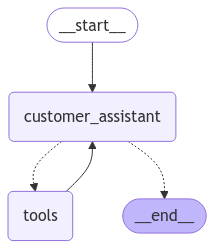

In [32]:

builder: StateGraph = StateGraph(MessagesState)

#adding noodes:
#node1
builder.add_node("customer_assistant", customer_assistant)
#node2

builder.add_node("tools",ToolNode(tools))

#adding edges:
builder.add_edge(START, "customer_assistant")
#conditional edges for making it REACT agent
builder.add_conditional_edges("customer_assistant",
            #if
                              tools_condition)
builder.add_edge("tools", "customer_assistant")

#compiling graph
react_graph: CompiledStateGraph = builder.compile()

#graph view
display(Image(react_graph.get_graph().draw_mermaid_png()))

Adding short term memory in chatbot

In [33]:
memory: MemorySaver= MemorySaver()
graph_with_memory: CompiledStateGraph= builder.compile(checkpointer=memory)

In [22]:
#defining specific thread id for chat
config1= {"configurable": {"thread_id": "1"}}

#human message
messages= [HumanMessage(content="123458")]

messages= graph_with_memory.invoke({"messages":messages},config1)


for m in messages["messages"]:
    m.pretty_print()


================================ Human Message =================================

who are you?
================================== Ai Message ==================================

I'm a customer service assistant here to help you with complaints, FAQs, and order tracking.
================================ Human Message =================================

w?
================================== Ai Message ==================================

I'm sorry, I'm not equipped to answer that question. My expertise lies in customer service related to complaints, FAQs, and order tracking. Is there anything else I can help you with regarding these areas?
================================ Human Message =================================

i want to track order?
================================== Ai Message ==================================

What is your order ID, please?
================================ Human Message =================================

12345?
================================== Ai Message ====